### Improving the model
The first thing we can try is having more data thanks to data augmentation. We will use the following steps:
- Randomly flip the images horizontally
- Randomly rotate the images by 20 degrees
- Randomly zoom the images by 20% (zoom in)
- Randomly zoom the images by 20% (zoom out)

In [1]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras import models

2022-12-17 20:51:56.652645: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-17 20:51:56.869928: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-17 20:51:56.869958: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-17 20:51:58.100611: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

In [2]:
train_ds, test_ds , val_ds= tfds.load('eurosat/rgb', split=['train[:60%]', 'train[60%:80%]', 'train[80%:]'], shuffle_files=False, as_supervised=True)

2022-12-17 20:52:01.587663: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-17 20:52:01.587696: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-17 20:52:01.587715: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (codespaces-488978): /proc/driver/nvidia/version does not exist
2022-12-17 20:52:01.588101: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
labels = []
for _, label in train_ds:
    labels.append(label.numpy())
labels = np.unique(labels)

In [4]:
BUFFER_SIZE = 1000
BATCH_SIZE = 32
img_height=64
img_width =64
IMG_SIZE = (img_height, img_width)
def resize_image(images, labels):
    images = tf.image.resize(images, IMG_SIZE)
    return images, labels

In [5]:
train_ds = train_ds.map(resize_image).batch(BATCH_SIZE)\
    .prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = val_ds.map(resize_image).batch(BATCH_SIZE)\
    .prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.map(resize_image).batch(BATCH_SIZE)\
    .prefetch(buffer_size=tf.data.AUTOTUNE)

In [6]:
data_augmentation = models.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
])

In [7]:
tf.keras.utils.set_random_seed(42)

model_aug = models.Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model_aug.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

In [8]:
# Make an early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [9]:
history_aug = model_aug.fit(train_ds, epochs=20, validation_data=val_ds, callbacks=[early_stopping])

Epoch 1/20


/home/codespace/.python/current/lib/python3.10/site-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


507/507 [==============================] - 38s 64ms/step - loss: 1.3680 - accuracy: 0.4656 - val_loss: 1.6035 - val_accuracy: 0.4344
Epoch 2/20
507/507 [==============================] - 25s 50ms/step - loss: 0.9639 - accuracy: 0.6478 - val_loss: 1.0127 - val_accuracy: 0.6278
Epoch 3/20
507/507 [==============================] - 33s 65ms/step - loss: 0.7591 - accuracy: 0.7223 - val_loss: 0.8803 - val_accuracy: 0.6754
Epoch 4/20
507/507 [==============================] - 30s 59ms/step - loss: 0.6663 - accuracy: 0.7598 - val_loss: 0.7087 - val_accuracy: 0.7378
Epoch 5/20
507/507 [==============================] - 20s 40ms/step - loss: 0.5991 - accuracy: 0.7819 - val_loss: 0.5864 - val_accuracy: 0.7833
Epoch 6/20
507/507 [==============================] - 20s 40ms/step - loss: 0.5593 - accuracy: 0.7937 - val_loss: 0.5463 - val_accuracy: 0.7998
Epoch 7/20
507/507 [==============================] - 20s 40ms/step - loss: 0.5308 - accuracy: 0.8069 - val_loss: 0.5426 - val_accuracy: 0.7998
Epo

In [10]:
test_loss, test_acc = model_aug.evaluate(test_ds)
print('Test accuracy: ', test_acc)

169/169 [==============================] - 2s 9ms/step - loss: 0.4239 - accuracy: 0.8594
Test accuracy:  0.8594444394111633


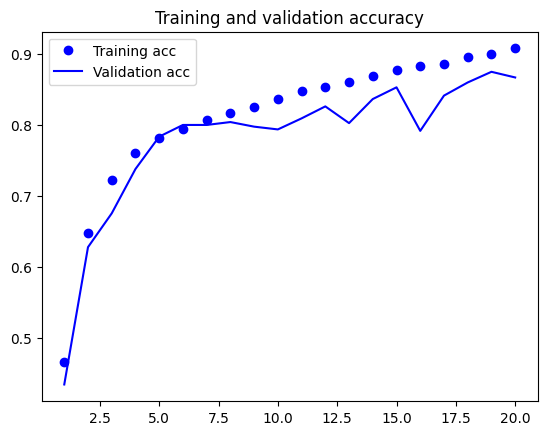

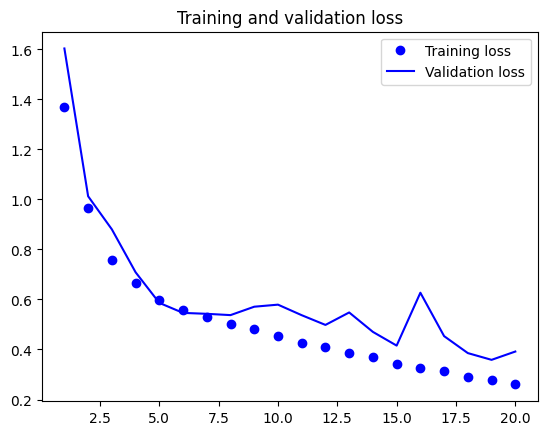

In [11]:
acc = history_aug.history['accuracy']
val_acc = history_aug.history['val_accuracy']
loss = history_aug.history['loss']
val_loss = history_aug.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

169/169 [==============================] - 1s 8ms/step


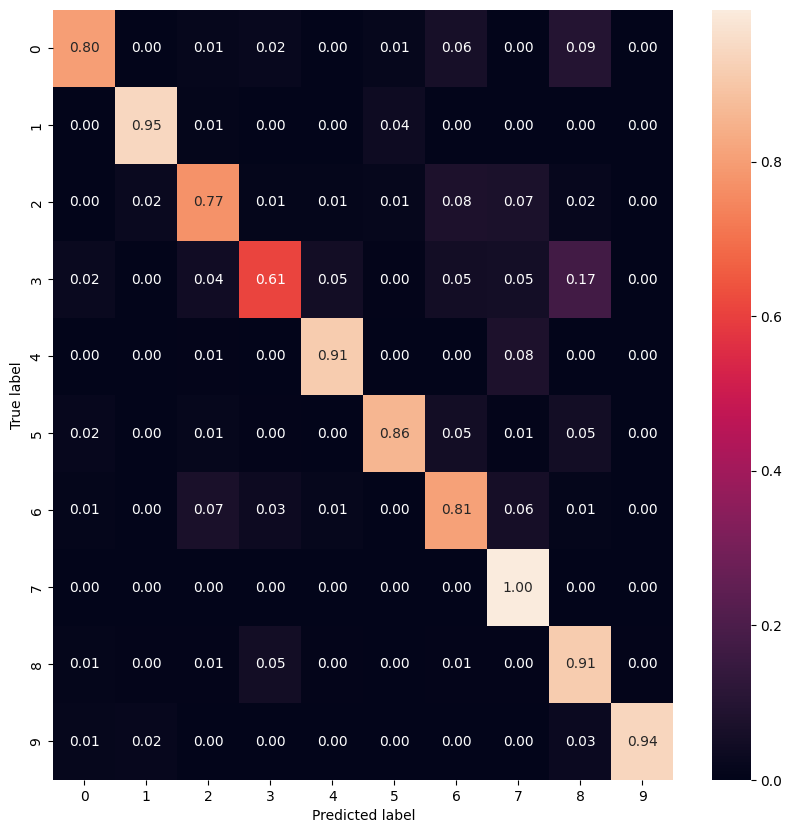

In [12]:
# Show the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model_aug.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = []
for _, label in test_ds:
    y_true.append(label.numpy())
y_true = np.concatenate(y_true)

cm = confusion_matrix(y_true, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [13]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.80      0.86       598
           1       0.95      0.95      0.95       593
           2       0.85      0.77      0.81       611
           3       0.81      0.61      0.70       461
           4       0.92      0.91      0.92       504
           5       0.90      0.86      0.88       446
           6       0.76      0.81      0.79       524
           7       0.81      1.00      0.89       599
           8       0.70      0.91      0.79       493
           9       0.99      0.94      0.96       571

    accuracy                           0.86      5400
   macro avg       0.86      0.86      0.85      5400
weighted avg       0.87      0.86      0.86      5400

